In [0]:
# Data download and unzipping for stage2
%%capture
!pip install kaggle
!mv kaggle.json .kaggle/
!kaggle competitions download -c data-science-bowl-2018 -f stage2_test_final.zip

!mkdir stage2_test_final
!unzip .kaggle/competitions/data-science-bowl-2018/stage2_test_final.zip -d stage2_test_final/

In [0]:
# Data download and unzipping for stage1
%%capture
!wget https://raw.githubusercontent.com/AakashSudhakar/2018-data-science-bowl/master/compressed_files/stage1_test.zip -c
!wget https://raw.githubusercontent.com/AakashSudhakar/2018-data-science-bowl/master/compressed_files/stage1_train.zip -c

!mkdir stage1_train stage1_test
!unzip stage1_train.zip -d stage1_train/
!unzip stage1_test.zip -d stage1_test/

In [1]:
!ls

datalab


In [4]:
from google.colab import files
uploaded = files.upload() # upload kaggle.json .py files

Saving data_utils.py to data_utils.py


In [0]:
%%capture
!pip install keras --upgrade

In [5]:
import os
import random
import sys
import warnings
import numpy as np
import pandas as pd
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from keras.models import Model, load_model
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

# Setting seed for reproducability
SEED = 42
np.random.seed(SEED)
%matplotlib inline

Using TensorFlow backend.


In [0]:
from data_utils import read_train_data, read_test_data, rle_encoding, mask_to_rle
from model import get_unet, iou_metric, iou_metric_batch, my_iou_metric

In [7]:
# get train_data
X_train,Y_train = read_train_data()
# get test_data
test_img,test_img_sizes = read_test_data()

Getting and resizing train images and masks ... 
669/670 [============================>.] - ETA: 0s
Getting and resizing test images ... 
63/65 [============================>.] - ETA: 0s

Leaderboard: 0.329: BATCH_SIZE = 32, EPOCHS = 100, LEARNING_RATE = 1e-3, OPTIMIZER = optimizers.Adam(), val_size = 0.25, kfold=4<br>
Leaderboard: 0.320: BATCH_SIZE = 16, EPOCHS = 50, LEARNING_RATE = 1e-3, OPTIMIZER = optimizers.Adam(), val_size = 0.25<br>
Leaderboard: 0.317: BATCH_SIZE = 16, EPOCHS = 50, LEARNING_RATE = 1e-3, OPTIMIZER = optimizers.Adam(), val_size = 0.25, kfold=4<br>
Leaderboard: 0.277: BATCH_SIZE = 16, EPOCHS = 50, LEARNING_RATE = 1e-3, OPTIMIZER = optimizers.Adam(), val_size = 0.2<br>

In [0]:
#@title Hyperparameter { run: "auto", display-mode: "both" }
BATCH_SIZE = 32 #@param {type:"raw"}
EPOCHS = 50 #@param {type:"raw"}
LEARNING_RATE = 1e-3 #@param {type:"raw"}
OPTIMIZER = optimizers.Adam(lr=LEARNING_RATE) #@param {type:"raw"}
val_size = 0.25 #@param {type:"raw"}

### Train/Val split, U-net model

In [0]:
train_img, val_img, train_mask, val_mask = train_test_split(X_train, Y_train, test_size=val_size, random_state=SEED)

train_size = len(train_img)
val_size = len(val_img)

In [0]:
# get u_net model
u_net = get_unet(OPTIMIZER=OPTIMIZER)
# u_net.summary()

### Training

In [11]:
print("Training...\n")
filepath="best_model.h5" # save best model only
earlystopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
checkpointer = ModelCheckpoint(filepath, monitor='val_my_iou_metric', 
                               verbose=1, save_best_only=True, mode='max')
results = u_net.fit(x=train_img, y=train_mask, validation_data=(val_img, val_mask), 
                   batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, 
                   callbacks=[earlystopper, checkpointer])

Training...

Train on 502 samples, validate on 168 samples
Epoch 1/50
502/502 [==============================] - 24s 47ms/step - loss: 0.6014 - my_iou_metric: 0.0000e+00 - val_loss: 0.4805 - val_my_iou_metric: 0.0000e+00

Epoch 00001: val_my_iou_metric improved from -inf to 0.00000, saving model to best_model.h5
Epoch 2/50
502/502 [==============================] - 14s 28ms/step - loss: 0.3877 - my_iou_metric: 0.0000e+00 - val_loss: 0.3427 - val_my_iou_metric: 0.0000e+00

Epoch 00002: val_my_iou_metric did not improve
Epoch 3/50
502/502 [==============================] - 14s 28ms/step - loss: 0.2808 - my_iou_metric: 0.0000e+00 - val_loss: 0.2671 - val_my_iou_metric: 0.0000e+00

Epoch 00003: val_my_iou_metric did not improve
Epoch 4/50
502/502 [==============================] - 14s 28ms/step - loss: 0.2446 - my_iou_metric: 7.2459e-05 - val_loss: 0.2232 - val_my_iou_metric: 0.0074

Epoch 00004: val_my_iou_metric improved from 0.00000 to 0.00737, saving model to best_model.h5
Epoch 5/50
5

192/502 [==========>...................] - ETA: 6s - loss: 0.0745 - my_iou_metric: 0.5132502/502 [==============================] - 14s 28ms/step - loss: 0.0708 - my_iou_metric: 0.5073 - val_loss: 0.0734 - val_my_iou_metric: 0.4897

Epoch 00035: val_my_iou_metric did not improve
Epoch 36/50
502/502 [==============================] - 14s 28ms/step - loss: 0.0694 - my_iou_metric: 0.5089 - val_loss: 0.0737 - val_my_iou_metric: 0.5227

Epoch 00036: val_my_iou_metric did not improve
Epoch 37/50
502/502 [==============================] - 14s 28ms/step - loss: 0.0702 - my_iou_metric: 0.5082 - val_loss: 0.0701 - val_my_iou_metric: 0.5244

Epoch 00037: val_my_iou_metric did not improve
Epoch 38/50
502/502 [==============================] - 14s 28ms/step - loss: 0.0662 - my_iou_metric: 0.5208 - val_loss: 0.0732 - val_my_iou_metric: 0.5328

Epoch 00038: val_my_iou_metric improved from 0.52800 to 0.53283, saving model to best_model.h5
Epoch 39/50
502/502 [==============================] - 14s 28ms

### Plot training history

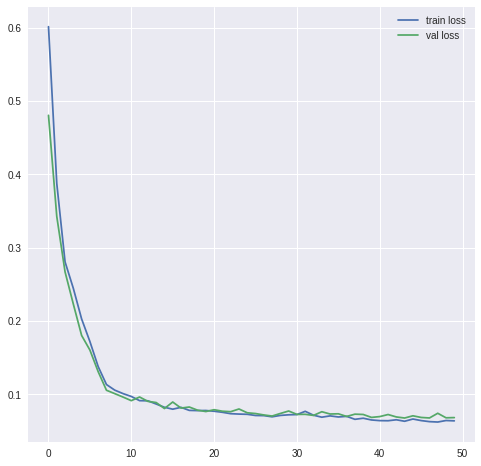

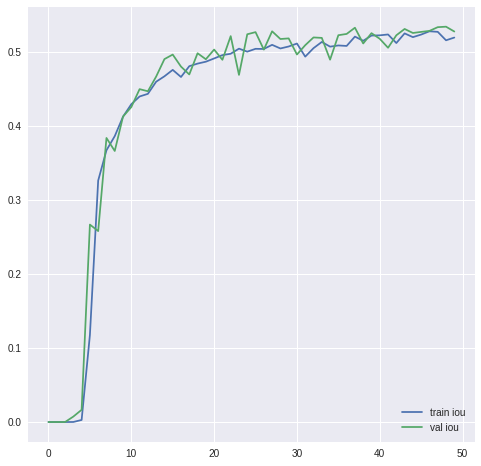

In [12]:
loss = results.history['loss']
val_loss = results.history['val_loss']
acc = results.history['my_iou_metric']
val_acc = results.history['val_my_iou_metric']
plt.figure(figsize=(8,8))
plt.plot(np.arange(len(loss)), np.array(loss), label='train loss')
plt.plot(np.arange(len(val_loss)), np.array(val_loss), label='val loss')
plt.legend(loc=1)

plt.figure(figsize=(8,8))
plt.plot(np.arange(len(acc)), np.array(acc), label='train iou')
plt.plot(np.arange(len(val_acc)), np.array(val_acc), label='val iou')
plt.legend(loc=4)

### Load best model and evaluate

In [13]:
best_model = load_model('best_model.h5', custom_objects={'my_iou_metric': my_iou_metric})
print('Predicting...')
train_pred = best_model.predict(train_img, verbose=1)
val_pred = best_model.predict(val_img, verbose=1)
test_pred = best_model.predict(test_img, verbose=1)
train_iou = iou_metric_batch(train_mask, train_pred)
val_iou = iou_metric_batch(val_mask, val_pred)
print('Best train IOU = ', train_iou)
print('Best val IOU = ', val_iou)

Predicting...
65/65 [==============================] - 1s 12ms/step
Best train IOU =  0.53829265
Best val IOU =  0.5342302


### Visualizations of val/test prediction

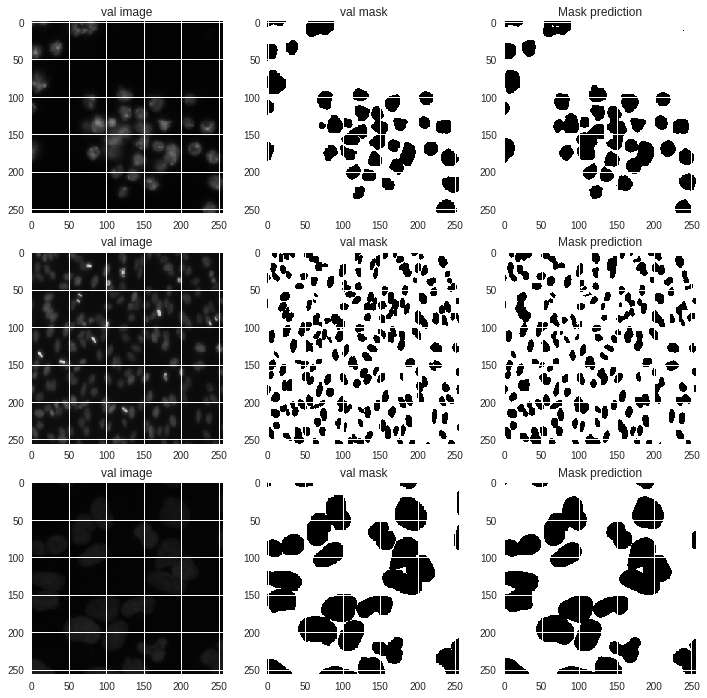

In [14]:
ids = np.random.choice(range(len(val_img)), 3, replace=False)
plt.figure(figsize=(12,12))
j = 0
for i in range(len(ids)):
    plt.subplot(331 + j)
    plt.imshow(val_img[ids[i]])
    plt.title("val image")
    plt.subplot(331 + j + 1)
    plt.imshow(np.squeeze(val_mask[ids[i]]))
    plt.title("val mask")
    plt.subplot(331 + j + 2)
    plt.imshow(np.squeeze(val_pred[ids[i]] > 0.5))
    plt.title("Mask prediction")
    j += 3
plt.show()

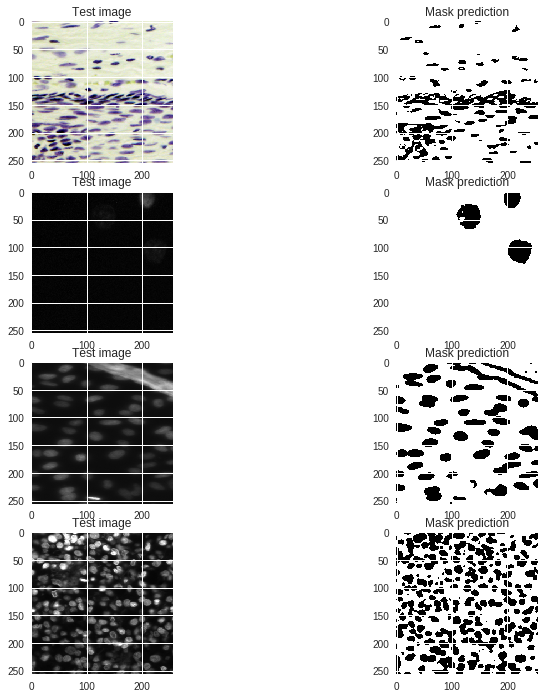

In [15]:
ids = np.random.choice(range(len(test_img)), 4, replace=False)
plt.figure(figsize=(12,12))
j = 0
for i in range(len(ids)):
    plt.subplot(421 + j)
    plt.imshow(test_img[ids[i]])
    plt.title("Test image")
    plt.subplot(421 + j + 1)
    j += 2
    plt.imshow(np.squeeze(test_pred[ids[i]] > 0.5))
    plt.title("Mask prediction")
plt.show()

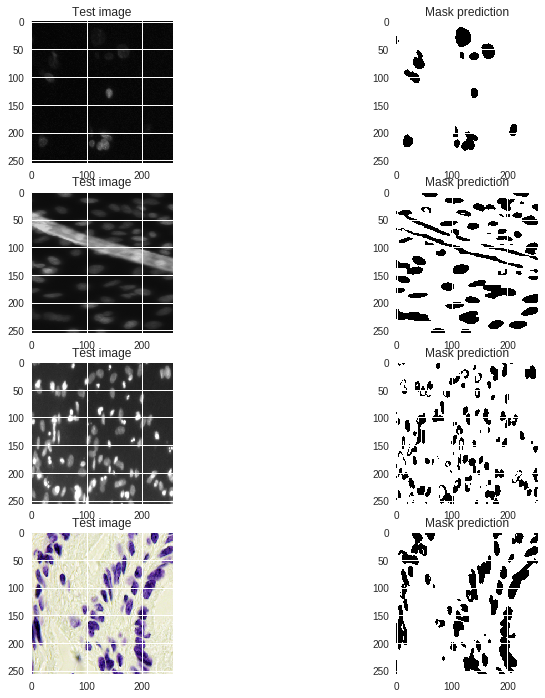

In [16]:
ids = np.random.choice(range(len(test_img)), 4, replace=False)
plt.figure(figsize=(12,12))
j = 0
for i in range(len(ids)):
    plt.subplot(421 + j)
    plt.imshow(test_img[ids[i]])
    plt.title("Test image")
    plt.subplot(421 + j + 1)
    j += 2
    plt.imshow(np.squeeze(test_pred[ids[i]] > 0.5))
    plt.title("Mask prediction")
plt.show()

### Train/Val split Submission

In [0]:
# Create list of upsampled test masks
test_mask_upsampled = []
for i in range(len(test_pred)):
    test_mask_upsampled.append(resize(np.squeeze(test_pred[i]),
                                       (test_img_sizes[i][0],test_img_sizes[i][1]), 
                                       mode='constant', preserve_range=True))

In [0]:
test_ids,rles = mask_to_rle(test_mask_upsampled)

In [0]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))

sub.to_csv('sub-dsbowl2018.csv', index=False)

In [0]:
# Code to download files from Google colab

from google.colab import files
files.download('sub-dsbowl2018.csv')
files.download('best_model.h5')